## Simulation results for N=100, 200, 1000 (update X interpolation, drop CV step 6)

In [2]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append('./SpLSI/pycvxcluster/src/')
import pycvxcluster.pycvxclt

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi

def run_simul(nsim, N_vals, n=1000, p=30, K=3, r=0.05, m=5, phi=0.1):
    results = []

    for N in N_vals:
        print(f"Running simulation for N={N}...")

        for _ in range(nsim):
            # Generate topic data and graph
            df, W, A, D = gen_model.generate_data(N, n, p, K, r)
            weights = gen_model.generate_weights(df, K, m, phi)

            # Vanilla SVD
            spl_v = splsi.SpLSI(lamb_start=0.0001, step_size=1.17, grid_len=50, method="nonspatial", verbose=0)
            spl_v.fit(D, K, df, weights)

            # Spatial SVD (two-step)
            spl_2 = splsi.SpLSI(lamb_start=0.0001, step_size=1.17, grid_len=50, step="two-step", verbose=0)
            spl_2.fit(D, K, df, weights)

            # Record [err, acc] for spl_v and spl_2
            P_v = get_component_mapping(spl_v.W_hat.T, W)
            P_2 = get_component_mapping(spl_2.W_hat.T, W)

            W_hat_v = spl_v.W_hat @ P_v
            W_hat_2 = spl_2.W_hat @ P_2
            err_acc_spl_v = [get_F_err(W_hat_v, W), get_accuracy(df, n, W_hat_v)]
            err_acc_spl_2 = [get_F_err(W_hat_2, W), get_accuracy(df, n, W_hat_2)]

            results.append({
                'N': N,
                'spl_2': spl_2,
                'vanilla_err': err_acc_spl_v[0],
                'vanilla_acc': err_acc_spl_v[1],
                'spatial_err': err_acc_spl_2[0],
                'spatial_acc': err_acc_spl_2[1],
                'spatial_lambd': spl_2.lambd
            })
            print(f"CV Lambda is {spl_2.lambd}")
    df_grouped = pd.DataFrame(results)

    return df_grouped

def plot_fold_cv(lamb_start, step_size, grid_len, model):
    lambd_errs = model.lambd_errs
    lambd_grid = (lamb_start*np.power(step_size, np.arange(grid_len))).tolist()
    lambd_grid.insert(0, 1e-06)
    cv_1 = np.round(lambd_grid[np.argmin(lambd_errs['fold_errors'][0])], 5)
    cv_2 = np.round(lambd_grid[np.argmin(lambd_errs['fold_errors'][1])], 5)
    cv_final = model.lambd
    for j, fold_errs in lambd_errs['fold_errors'].items():
        plt.plot(lambd_grid, fold_errs, label=f'Fold {j}', marker = 'o')
        #plt.vlines(cv_1, 18.90, 18.25, color = "blue")
        #plt.vlines(cv_2, 18.90, 18.25, color = "orange")

    #plt.plot(lambd_grid, new_list, label='Final Errors', linestyle='--', linewidth=2)
    plt.xlabel('Lambda')
    plt.ylabel('Errors')
    plt.text(cv_1, lambd_errs['fold_errors'][0][0], cv_1, color='blue')
    plt.text(cv_1, lambd_errs['fold_errors'][1][0], cv_2, color='orange')
    plt.title(f'N={N}, Lambda CV = {cv_final}')
    plt.legend()
    plt.show()


In [2]:
res = run_simul(nsim = 5, N_vals=[100, 200, 1000])

Running simulation for N=100...


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 4 steps.
CV Lambda is 0.005065782550001516


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 4 steps.
CV Lambda is 0.008113423187255575


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.006934549732697075


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 4 steps.
CV Lambda is 0.006934549732697075


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.008113423187255575
Running simulation for N=200...


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.005926965583501773


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.006934549732697075


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.005926965583501773


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.006934549732697075


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 3 steps.
CV Lambda is 0.003162925469511996
Running simulation for N=1000...


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.
CV Lambda is 0.004329728675214971


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.
CV Lambda is 0.004329728675214971


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.
CV Lambda is 0.005065782550001516


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.
CV Lambda is 0.006934549732697075


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.
CV Lambda is 0.006934549732697075


In [9]:
res.to_csv('sim_cv1_mean.csv')

[Text(0.5, 1.0, 'N vs MSE')]

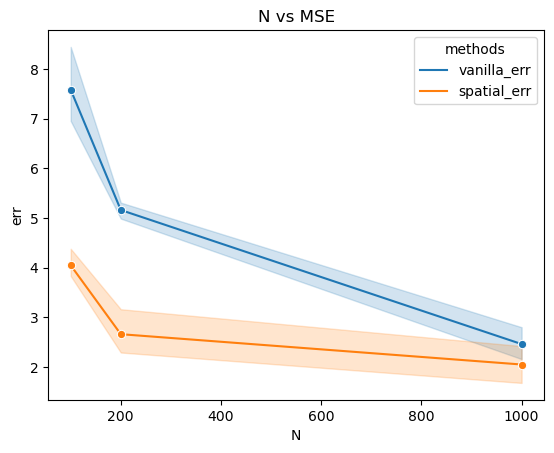

In [4]:
df_melted = pd.melt(res[['vanilla_err','spatial_err','N']], id_vars='N', var_name='methods', value_name='err')
sns.lineplot(x='N', y='err', hue = 'methods', data=df_melted, marker='o').set(title='N vs MSE')


[Text(0.5, 1.0, 'N vs Accuracy')]

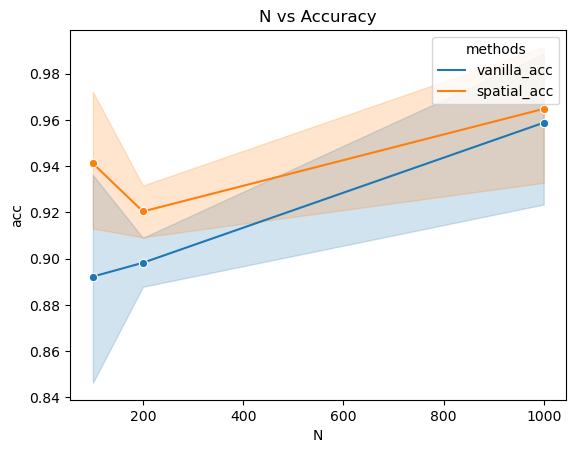

In [5]:
df_melted = pd.melt(res[['vanilla_acc','spatial_acc','N']], id_vars='N', var_name='methods', value_name='acc')
sns.lineplot(x='N', y='acc', hue = 'methods', data=df_melted, marker='o').set(title='N vs Accuracy')

[Text(0.5, 1.0, 'N vs Lambda CV')]

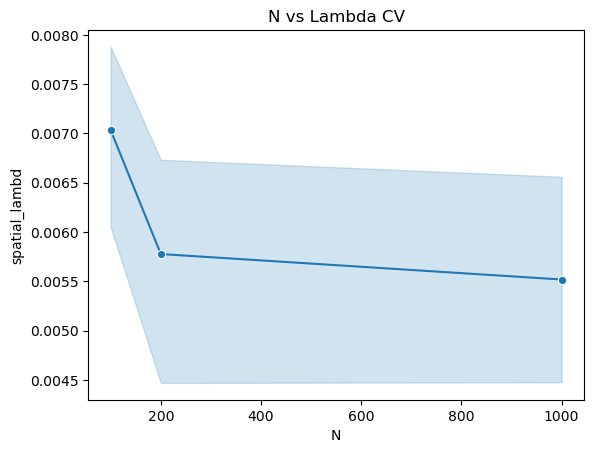

In [6]:
sns.lineplot(x='N', y='spatial_lambd', data=res, marker='o').set(title='N vs Lambda CV')

## Lambda path for one simulation (N=1000)

In [6]:
N=1000
n=1000
p=30
K=3
r=0.05
m=5
phi=0.1
df, W, A, D = gen_model.generate_data(N, n, p, K, r)
weights = gen_model.generate_weights(df, K, m, phi)
spatial = splsi.SpLSI(lamb_start=0.0001, step_size=1.15, grid_len=50, step="two-step", verbose=0) 
spatial.fit(D, K, df, weights)      

/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


SpatialSVD ran for 2 steps.


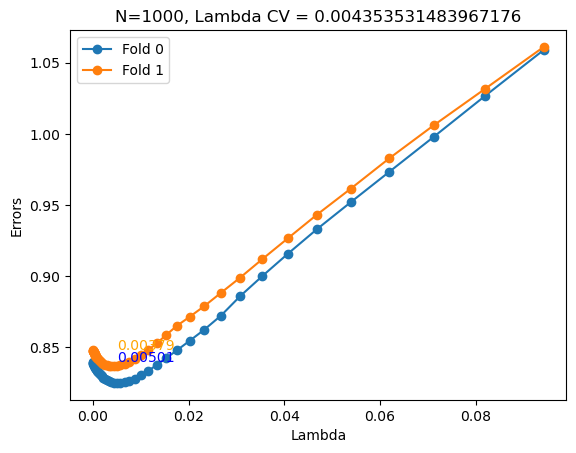

In [7]:
plot_fold_cv(lamb_start=0.0001, step_size=1.15, grid_len=50, model = spatial)